# <center>Đồ án 3: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Lê Thị Hoài Thư
- MSSV: 21127176
- Lớp: 21CLC02

# Import

In [115]:
import pandas as pd
import numpy as np

# Import thêm dữ thư viện nếu cần
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
from scipy.stats import pearsonr
from sklearn.feature_selection import VarianceThreshold

In [116]:
np.set_printoptions(precision=3)    # làm tròn đến chữ số thập phân thứ 3 khi in ra

# Đọc dữ liệu

In [117]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa các đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu kiểm tra)

X_test = test.iloc[:, :-1]      # Dataframe (chứa các đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần
headers = list(train.columns.values)

# Cài đặt hàm

In [118]:
# Cài đặt các hàm cần thiết ở đây

class OLSLinearRegression:
    def fit(self, X, y):
        X_pinv = np.linalg.inv(X.T @ X) @ X.T
        # X_pinv = np.linalg.pinv(X)
        self.w = X_pinv @ y

        return self

    def get_params(self):
        return self.w

    def predict(self, X):
        return np.sum(self.w.ravel() * X, axis=1)
    

def train_lr_model(features):
    X = np.array(X_train[features])
    y = y_train

    return OLSLinearRegression().fit(X, y)  #lr_model

def divide_size(size, k_fold=5):
    spare = size%k_fold
    res = np.ones(k_fold)*(size//k_fold)
    res[-spare:] = res[-spare:]+1
    return res.astype(int)

def rank_features(features, k_fold=5):
    shuffled_train = shuffle(train)
    
    X_train = shuffled_train.loc[:, features]
    y_train = shuffled_train.iloc[:, -1]

    start = 0
    mae_table = np.zeros((len(features), k_fold))
    sample_size = divide_size(shuffled_train.shape[0])

    for sample_id in range(k_fold):
        X_sample = X_train.iloc[start:start+sample_size[sample_id],:]
        y_sample = y_train[start:start+sample_size[sample_id]]

        start = start+sample_size[sample_id]

        for feature_id in range(len(features)):
            X_temp = np.array(X_sample[[features[feature_id]]])
            lr_temp = OLSLinearRegression().fit(X_temp, y_sample)
            y_predict = lr_temp.predict(X_temp)

            mae_table[feature_id, sample_id] = mean_absolute_error(y_sample, y_predict)

    return np.mean(mae_table, axis=1).reshape(-1, 1)

def rank_models(features, k_fold=5):
    shuffled_train = shuffle(train)

    X_train = shuffled_train.iloc[:, :-1]
    y_train = shuffled_train.iloc[:, -1]
    
    start = 0
    mae_table = np.zeros((len(features), k_fold))
    sample_size = divide_size(shuffled_train.shape[0])

    for sample_id in range(k_fold):
        X_sample = X_train.iloc[start:start+sample_size[sample_id],:]
        y_sample = y_train[start:start+sample_size[sample_id]]

        start = start+sample_size[sample_id]

        for model_id in range(len(features)):
            X_temp = np.array(X_sample[features[model_id]])
            lr_temp = OLSLinearRegression().fit(X_temp, y_sample)
            y_predict = lr_temp.predict(X_temp)
            
            mae_table[model_id, sample_id] = mean_absolute_error(y_sample, y_predict)
    
    return np.mean(mae_table, axis=1).reshape(-1, 1)

# Yêu cầu 1a: Sử dụng toàn bộ 11 đặc trưng đầu tiên `Gender`, `10percentage`, `12percentage`, `CollegeTier`, `Degree`, `collegeGPA`, `CollegeCityTier`, `English`, `Logical`, `Quant`, `Domain` (2 điểm) 

In [119]:
# Phần code cho yêu cầu 1a
features = headers[:11]
lr_1a_model = train_lr_model(features)

print('params: ', lr_1a_model.get_params())

params:  [-22756.513    804.503   1294.655 -91781.898  23182.389   1437.549
  -8570.662    147.858    152.888    117.222  34552.286]


In [120]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
X_1a = X_test[features]
y_predict = lr_1a_model.predict(X_1a)

print('MAE: ', mean_absolute_error(y_test, y_predict))

MAE:  104863.77754033315


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = - \texttt{22756.513}\times\text{Gender} + \texttt{804.503}\times\text{10percentage} + \texttt{1294.655}\times\text{12percentage} - \texttt{91781.898}\times\text{CollegeTier} \\ + \texttt{23182.389}\times\text{Degree} + \texttt{1437.549}\times\text{collegeGPA} - \texttt{8570.662}\times\text{CollegeCityTier} + \texttt{147.858}\times\text{English} \\ + \texttt{152.888}\times\text{Logical} + \texttt{117.222}\times\text{Quant} + \texttt{34552.286}\times\text{Domain} $$

# Yêu cầu 1b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng tính cách với các đặc trưng tính cách gồm `conscientiousness`, `agreeableness`, `extraversion`, `nueroticism`, `openess_to_experience`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [121]:
# Phần code cho yêu cầu 1b
features = headers[-6:-1]
mae_table_1b = rank_features(features)


# Tìm ra đặc trưng tốt nhất
best_feature_1b = features[np.argmin(mae_table_1b)]
print('Best feature: ', best_feature_1b)


# In ra các kết quả cross-validation như yêu cầu
df = pd.DataFrame(features, columns=['Mô hình với 1 đặc trưng'])
df.insert(1, "MAE", mae_table_1b)
df

Best feature:  nueroticism


,Mô hình với 1 đặc trưng,MAE
0,conscientiousness,306050.988724
1,agreeableness,299551.981134
2,extraversion,306479.198471
3,nueroticism,298777.860488
4,openess_to_experience,302984.477790


In [122]:
# Huấn luyện lại mô hình best_personality_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
best_personality_feature_model = train_lr_model([best_feature_1b])

print('params: ', best_personality_feature_model.get_params())

params:  [-56546.304]


In [123]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_personality_feature_model
X_1b = X_test[[best_feature_1b]]
y_predict = best_personality_feature_model.predict(X_1b)

print('MAE: ', mean_absolute_error(y_test, y_predict))

MAE:  291019.693226953


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = - \texttt{56546.304} \times \text{nueroticism}$$

# Yêu cầu 1c: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng `English`, `Logical`, `Quant`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [124]:
# Phần code cho yêu cầu 1c

features = ['English','Logical','Quant']
mae_table_1c = rank_features(features)


# Tìm ra đặc trưng tốt nhất
best_feature_1c = features[np.argmin(mae_table_1c)]
print('Best feature: ', best_feature_1c)


# In ra các kết quả cross-validation như yêu cầu
df = pd.DataFrame(features, columns=['Mô hình với 1 đặc trưng'])
df.insert(1, "MAE", mae_table_1c)
df

Best feature:  Quant


,Mô hình với 1 đặc trưng,MAE
0,English,121768.911445
1,Logical,120093.384910
2,Quant,118008.439300


In [125]:
# Huấn luyện lại mô hình best_skill_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện

best_skill_feature_model = train_lr_model([best_feature_1c])

print('params: ', best_skill_feature_model.get_params())

params:  [585.895]


In [126]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_skill_feature_model

X_1c = X_test[[best_feature_1c]]
y_predict = best_skill_feature_model.predict(X_1c)

print('MAE: ', mean_absolute_error(y_test, y_predict))

MAE:  106819.5776198967


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = \texttt{585.895}\times\text{Quant}$$

# Yêu cầu 1d: Sinh viên tự xây dựng mô hình, tìm mô hình cho kết quả tốt nhất (3 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

## Tìm mô hình

array([[<Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': '10percentage'}>,
        <Axes: title={'center': '12percentage'}>,
        <Axes: title={'center': 'CollegeTier'}>,
        <Axes: title={'center': 'Degree'}>],
       [<Axes: title={'center': 'collegeGPA'}>,
        <Axes: title={'center': 'CollegeCityTier'}>,
        <Axes: title={'center': 'English'}>,
        <Axes: title={'center': 'Logical'}>,
        <Axes: title={'center': 'Quant'}>],
       [<Axes: title={'center': 'Domain'}>,
        <Axes: title={'center': 'ComputerProgramming'}>,
        <Axes: title={'center': 'ElectronicsAndSemicon'}>,
        <Axes: title={'center': 'ComputerScience'}>,
        <Axes: title={'center': 'MechanicalEngg'}>],
       [<Axes: title={'center': 'ElectricalEngg'}>,
        <Axes: title={'center': 'TelecomEngg'}>,
        <Axes: title={'center': 'CivilEngg'}>,
        <Axes: title={'center': 'conscientiousness'}>,
        <Axes: title={'center': 'agreeableness'}>],
      

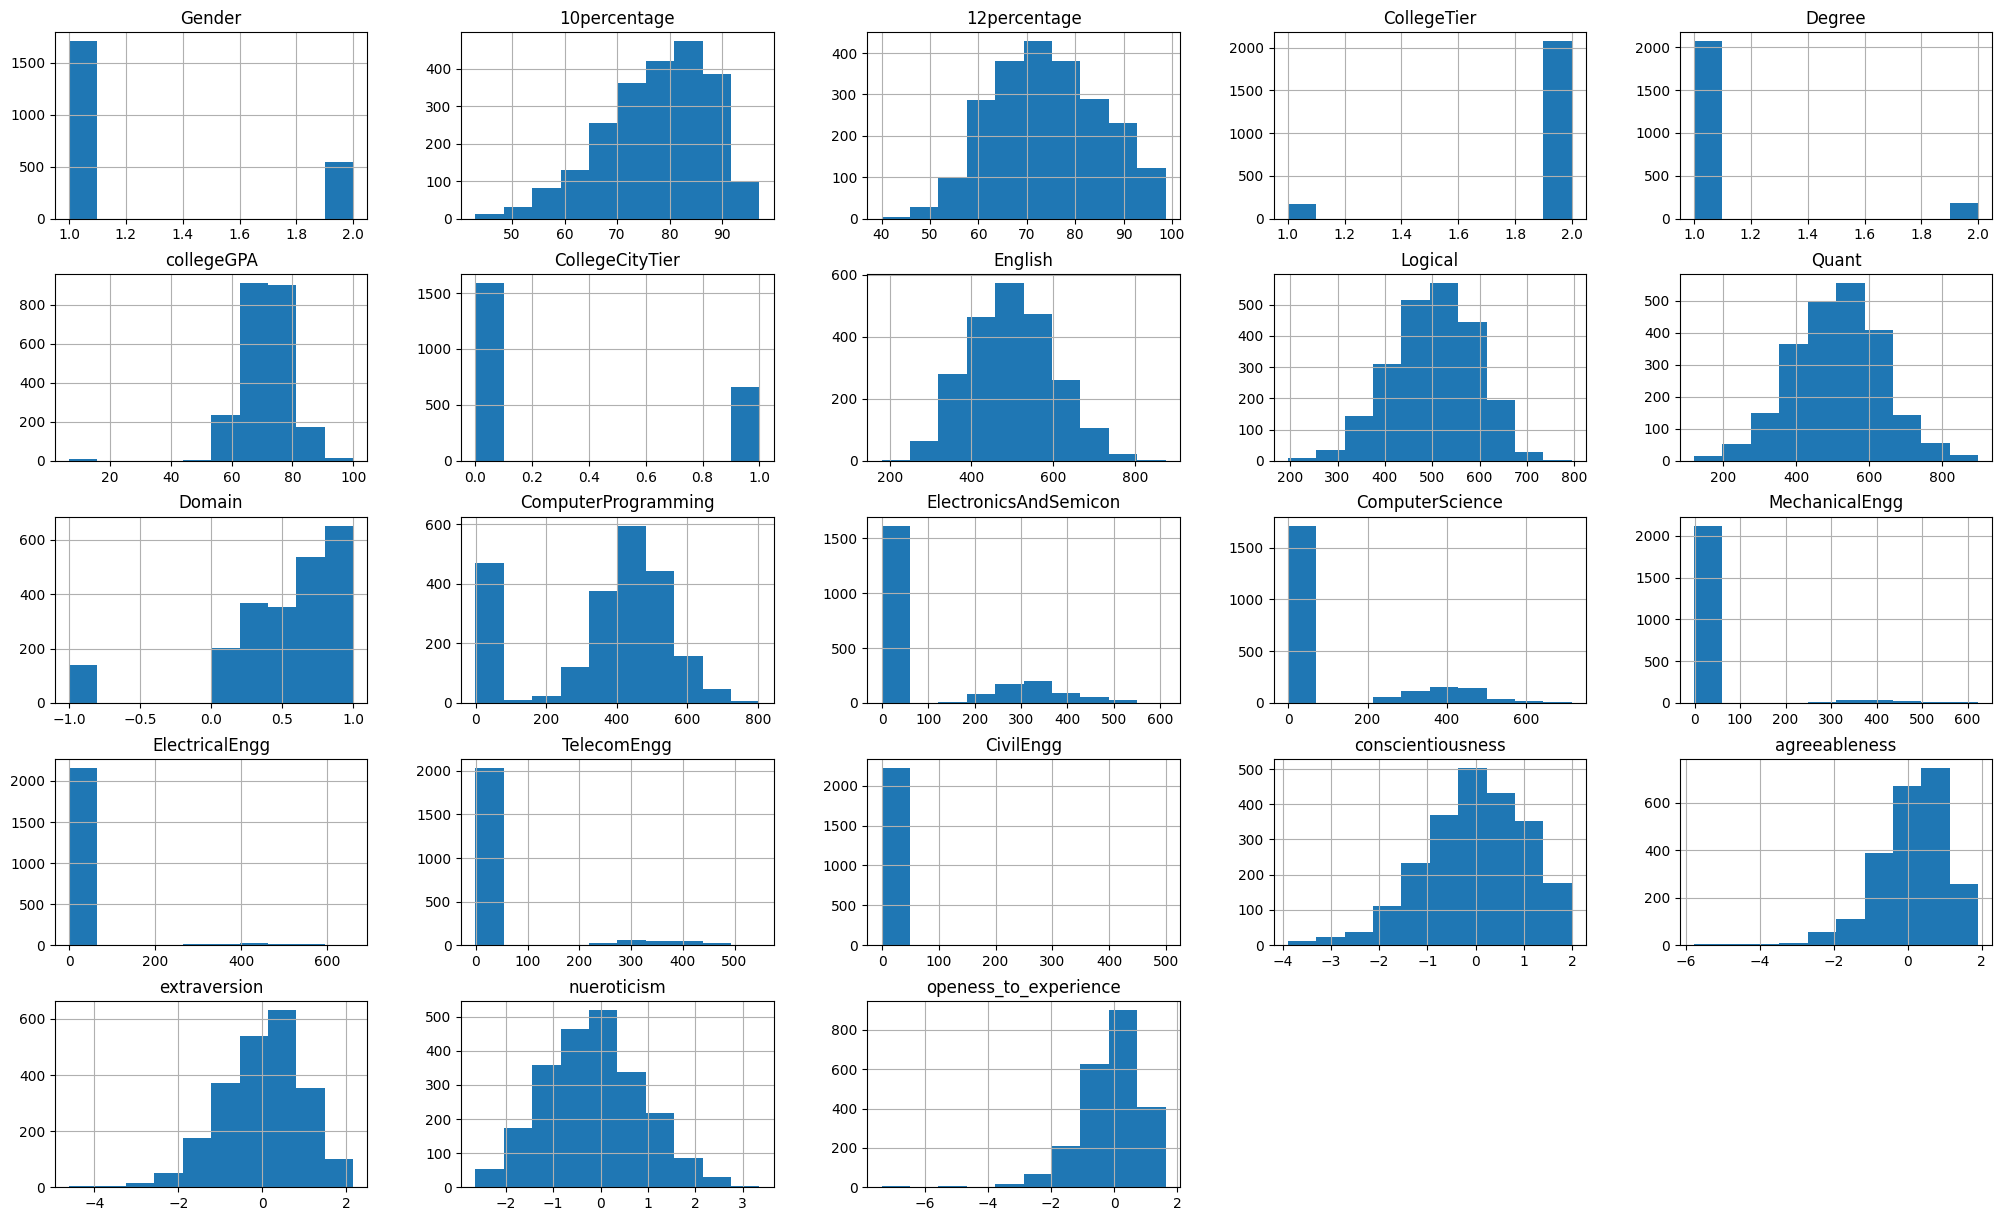

In [127]:
# Trình bày các phần tìm ra mô hình
features = headers[:-1]

df = X_train
df.hist(
    figsize=[25, 15]
)

In [128]:
v_threshold = VarianceThreshold(threshold=1)
v_threshold.fit_transform(X_train)

features_1 = v_threshold.get_feature_names_out()

model_1 = train_lr_model(features_1)

print('Đặc trưng được chọn: ', features_1)
print('params: ', model_1.get_params())

Đặc trưng được chọn:  ['10percentage' '12percentage' 'collegeGPA' 'English' 'Logical' 'Quant'
 'ComputerProgramming' 'ElectronicsAndSemicon' 'ComputerScience'
 'MechanicalEngg' 'ElectricalEngg' 'TelecomEngg' 'CivilEngg'
 'conscientiousness' 'nueroticism' 'openess_to_experience']
params:  [   133.762    784.061    116.779    150.118     97.335    170.509
    110.465    -24.348   -177.727     78.234   -129.812    -67.186
    143.509 -16949.383 -14762.542   3391.251]


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = \texttt{133.762}\times\text{10percentage} + \texttt{784.061}\times\text{12percentage} + \texttt{116.779}\times\text{collegeGPA} + \texttt{150.118}\times\text{English} \\ + \texttt{97.335}\times\text{Logical} + \texttt{170.509}\times\text{Quant} + \texttt{110.465}\times\text{ComputerProgramming} - \texttt{24.348}\times\text{ElectronicsAndSemicon} - \texttt{177.727}\times\text{ComputerScience} \\ + \texttt{78.234}\times\text{MechanicalEngg} - \texttt{129.812}\times\text{ElectricalEngg} - \texttt{67.186}\times\text{TelecomEngg} + \texttt{143.509}\times\text{CivilEngg} - \texttt{16949.383}\times\text{conscientiousness}\\ - \texttt{14762.542}\times\text{nueroticism} + \texttt{3391.251}\times\text{openess\_to\_experience}$$

In [129]:
coef = np.zeros((len(features)))
features = headers[:-1]

for _ in range(len(features)):
    x = X_train[features[_]]
    y= y_train
    coef[_] = pearsonr(x, y)[0]

features_2 = []
for _ in range(len(features)):
    if (coef[_]>0.1):
        features_2.append(features[_])

features_2 = np.array(features_2)

model_2 = train_lr_model(features_2)

print('Đặc trưng được chọn: ', features_2)
print('params: ', model_2.get_params())

df = pd.DataFrame(features, columns=['Feature'])
df.insert(1, "Correlation Coefficient", coef)
df

Đặc trưng được chọn:  ['10percentage' '12percentage' 'collegeGPA' 'English' 'Logical' 'Quant'
 'Domain' 'ComputerProgramming']
params:  [  128.91    795.645   -57.705   127.553   101.133   178.235 25767.594
    69.634]


,Feature,Correlation Coefficient
0,Gender,-0.036183
1,10percentage,0.155174
2,12percentage,0.149531
3,CollegeTier,-0.174824
4,Degree,-0.017602
5,collegeGPA,0.122469
6,CollegeCityTier,0.004575
7,English,0.169293
8,Logical,0.188416
9,Quant,0.205358


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = \texttt{128.91}\times\text{10percentage} + \texttt{795.645}\times\text{12percentage} - \texttt{57.705}\times\text{collegeGPA} + \texttt{127.553}\times\text{English} \\ + \texttt{101.133}\times\text{Logical} + \texttt{178.235}\times\text{Quant} + \texttt{25767.594}\times\text{Domain} + \texttt{69.634}\times\text{ComputerProgramming}$$

In [130]:
# min = mae_table_1c[np.argmin(mae_table_1c)]
# features_3 = np.array(['10percentage','12percentage','collegeGPA','Quant','Domain','ComputerProgramming','ElectronicsAndSemicon','ComputerScience','MechanicalEngg','ElectricalEngg','TelecomEngg','CivilEngg','nueroticism'])

# res = features_3

# check = np.zeros((len(features_3)), dtype=int)
# while (all(check==1)==False):
#     for _ in reversed(range(0, len(features_3))):
#         if check[_]==0:
#             check[_]=1
#             check[_+1:]=0
#             break


#     features_test = features_3[check==1]
#     model_temp = train_lr_model(features_test)

#     X = X_test[features_test]
#     y_predict = model_temp.predict(X)

#     if (mean_absolute_error(y_test, y_predict)<min):
#         min = mean_absolute_error(y_test, y_predict)
#         res = features_test

# features_3 = res

                #   Code được comment là code vét cạn chọn các đặc trưng tốt nhất cho mô hình từ 13 đặc trưng có biểu đồ tốt

features_3 = ['10percentage','12percentage','Quant','Domain','ComputerProgramming','ElectronicsAndSemicon','ComputerScience','ElectricalEngg','CivilEngg']
model_3 = train_lr_model(features_3)

print('Đặc trưng được chọn: ', features_3)
print('params: ', model_3.get_params())

Đặc trưng được chọn:  ['10percentage', '12percentage', 'Quant', 'Domain', 'ComputerProgramming', 'ElectronicsAndSemicon', 'ComputerScience', 'ElectricalEngg', 'CivilEngg']
params:  [ 1182.019   856.921   248.862 32146.875    92.867   -69.901  -169.944
  -143.188   133.199]


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = \texttt{1182.019}\times\text{10percentage} + \texttt{856.921}\times\text{12percentage} + \texttt{248.862}\times\text{Quant} + \texttt{32146.875}\times\text{Domain} + \texttt{92.867}\times\text{ComputerProgramming}\\ - \texttt{69.901}\times\text{ElectronicsAndSemicon} - \texttt{169.944}\times\text{ComputerScience} - \texttt{143.188}\times\text{ElectricalEngg} + \texttt{133.199}\times\text{CivilEngg}$$

## Thử nghiệm, so sánh các mô hình

In [131]:
# Phần code cho yêu cầu 1d
# Tìm ra mô hình tốt nhất (tự thiết kế bởi sinh viên)
# In ra các kết quả cross-validation như yêu cầu

features_arr = [features_1, features_2, features_3]
mae_table_1d = rank_models(features_arr)


# Tìm ra đặc trưng tốt nhất
best_features = features_arr[np.argmin(mae_table_1d)]
print('Best features: ',len(best_features), 'đặc trưng ', best_features)


text1 = 'Sử dụng 16 đặc trưng (10percentage, 12percentage, collegeGPA, English, Logical, Quant, ComputerProgramming, ElectronicsAndSemicon, ComputerScience, MechanicalEngg, ElectricalEngg, TelecomEngg, CivilEngg, conscientiousness, nueroticism, openess_to_experience)'
text2 = 'Sử dụng 8 đặc trưng (10percentage, 12percentage, collegeGPA, English, Logical, Quant, Domain, ComputerProgramming)'
text3 = 'Sử dụng 9 đặc trưng (10percentage, 12percentage, Quant, Domain, ComputerProgramming, ElectronicsAndSemicon, ComputerScience, ElectricalEngg, CivilEngg)'

# In ra các kết quả cross-validation như yêu cầu
df = pd.DataFrame([text1, text2, text3], columns=['Mô hình'])
df.insert(1, "MAE", mae_table_1d)
df


Best features:  9 đặc trưng  ['10percentage', '12percentage', 'Quant', 'Domain', 'ComputerProgramming', 'ElectronicsAndSemicon', 'ComputerScience', 'ElectricalEngg', 'CivilEngg']


,Mô hình,MAE
0,"Sử dụng 16 đặc trưng (10percentage, 12percenta...",112422.838359
1,"Sử dụng 8 đặc trưng (10percentage, 12percentag...",114679.272052
2,"Sử dụng 9 đặc trưng (10percentage, 12percentag...",112018.903220


In [132]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện
my_best_model = train_lr_model(best_features)

print('params: ', my_best_model.get_params())

params:  [ 1182.019   856.921   248.862 32146.875    92.867   -69.901  -169.944
  -143.188   133.199]


In [133]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model

X_1d = X_test[best_features]
y_predict = my_best_model.predict(X_1d)

print('MAE: ',mean_absolute_error(y_test, y_predict))

MAE:  101971.5226723628


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = \texttt{1182.019}\times\text{10percentage} + \texttt{856.921}\times\text{12percentage} + \texttt{248.862}\times\text{Quant} + \texttt{32146.875}\times\text{Domain} + \texttt{92.867}\times\text{ComputerProgramming}\\ - \texttt{69.901}\times\text{ElectronicsAndSemicon} - \texttt{169.944}\times\text{ComputerScience} - \texttt{143.188}\times\text{ElectricalEngg} + \texttt{133.199}\times\text{CivilEngg}$$